In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pyvista as pv

from sar_sim_mesh import SARSimulator
from geom import plot_radar_trajectory_and_object, place_object_on_terrain, mesh_to_facets

In [2]:
import rasterio
from terrain_sim import TerrainSimulator
# 1) Terrain 생성 + roughness map
# terrain = TerrainSimulator(kind="hill", nx=301, ny=301)
# terrain_mesh = terrain.build()

terrain = TerrainSimulator(tif_path="./tiles_2km/utm2km_r00_c11_E434087_N4210698.tif", max_size=1500, z_scale=1.0)
terrain_mesh = terrain.build()
# terrain_mesh.plot()

_, c_ter, n_ter, a_ter, r_ter = terrain.facets_with_roughness()
print("terrain shape:", len(c_ter))
print("terrain bound:", terrain_mesh.bounds[0], terrain_mesh.bounds[1], terrain_mesh.bounds[2],
      terrain_mesh.bounds[3], terrain_mesh.bounds[4], terrain_mesh.bounds[5])

# hist, bins = np.histogram(terrain.Z)
# plt.figure()
# plt.plot(bins[:-1], hist)
# plt.show()

terrain shape: 8712
terrain bound: -990.0000000000582 989.9999999999418 -989.9999999990687 990.0000000009313 674.5540161132812 1116.1820068359375


In [3]:
# 2) Object 로드 + terrain 위 배치
stl_path = "F16.stl"
obj_raw = pv.read(stl_path).triangulate()

obj_xyz = [
    [0., 0., 0.],
    [10., 0., 0.],
    [50., 0., 0.],
    [-50., 0., 0.],
    [-10., 0., 0.],
    [10., 10., 0.],
    [50., 10., 0.],
    [-50., -10., 0.],
    [-10., -10., 0.],    
    ]
c_objs = []
obj_meshes = []
for xyz in obj_xyz:
        
    obj_mesh = place_object_on_terrain(
        obj_mesh=obj_raw,
        height_fn=terrain.height_fn,
        xyz=xyz,          # (x, y, z) 추가로 올리고 싶으면 z에 값
        rpy_deg=(0.0, 90.0, 90.0),   # roll, pitch, yaw (deg)
        rotate_about="center",
        z_offset=0.0
    )
    
    # print("obj z bounds:", obj_mesh.bounds[4], obj_mesh.bounds[5]) # [4]:min, [5]:max
    _, c_obj, n_obj, a_obj = mesh_to_facets(obj_mesh)
    
    obj_meshes.append(obj_mesh)
    c_objs.append(c_obj)
    
c_objs = np.reshape(c_objs, (-1,3))
print(c_objs.shape)
print("centers object shape:", c_objs.shape)

(36828, 3)
centers object shape: (36828, 3)


In [4]:
# # (옵션) 씬 확인

# plotter = pv.Plotter()
# plotter.add_mesh(
#     terrain_mesh,
#     # color="lightgray",
#     cmap="terrain",
#     show_edges=True,
#     edge_color="black",
#     line_width=0.5
#     )
# # plotter.add_mesh(terrain_mesh, scalars="elevation", cmap="terrain", show_edges=False)
# for obj in obj_meshes:
#     plotter.add_mesh(obj, color="lightgray", show_edges=False)
    
# all_bounds = None

# for obj in obj_meshes:
#     if obj.n_points == 0:
#         continue
#     b = np.array(obj.bounds)  # (xmin,xmax,ymin,ymax,zmin,zmax)
#     all_bounds = b if all_bounds is None else np.array([
#         min(all_bounds[0], b[0]), max(all_bounds[1], b[1]),
#         min(all_bounds[2], b[2]), max(all_bounds[3], b[3]),
#         min(all_bounds[4], b[4]), max(all_bounds[5], b[5]),
#     ])
# print("scene bounds:", all_bounds)
# print("terrain bound:", terrain_mesh.bounds[0], terrain_mesh.bounds[1], terrain_mesh.bounds[2],
#       terrain_mesh.bounds[3], terrain_mesh.bounds[4], terrain_mesh.bounds[5])
# # for i, obj in enumerate(obj_meshes):
# #     print(i,
# #           "n_points:", obj.n_points,
# #           "n_cells:", obj.n_cells,
# #           "is_all_finite:", np.isfinite(obj.points).all(),
# #           "bounds:", obj.bounds)


# plotter.camera_position = "xy"   # 위에서 내려다봄
# plotter.camera.zoom(1.2)
# # plotter.camera.clipping_range = (0.1, 2e3)  # ✅ 멀리 있는 큰 씬이면 효과 큼

# # plotter.camera_position = [
# #     (1000, -1000, 800),  # camera
# #     (0, 0, 0),           # focal point
# #     (0, 0, 1)            # up vector
# # ]
# plotter.add_axes()
# plotter.show()

In [5]:
roi_x = 1000
roi_y = 1000

In [6]:
sar = SARSimulator(
    f0=5e9, bandwidth=300e6,
    az_start=-3, az_end=3, radius=1000,
    window_type="Hanning",
    targets=c_ter, rcs=None,
    # x_span=100, y_span=100,
    x_span=roi_x, y_span=roi_y,
    use_cupy=True,
    chunk_facets=10000
)

In [7]:
# signal, freqs, ref_points =sar.generate_phase_history(use_farfield=True)
signal, freqs, ref_points =sar.generate_phase_history_fused(use_farfield=True)
p_signal = sar.postprocess(signal)
print("signal shape: ", signal.shape)

(3,)
sensor xyz shape:  (283039, 3)
number of antenna(pulses) / frequency: 283039 / 2830
[PH fused] 1/283039
[PH fused] 28304/283039
[PH fused] 56607/283039
[PH fused] 84910/283039
[PH fused] 113213/283039
[PH fused] 141516/283039
[PH fused] 169819/283039
[PH fused] 198122/283039
[PH fused] 226425/283039
[PH fused] 254728/283039
[PH fused] 283031/283039


OutOfMemoryError: Out of memory allocating 6,408,003,072 bytes (allocated so far: 6,410,302,976 bytes).

(3,)
sensor xyz shape:  (56608, 3)


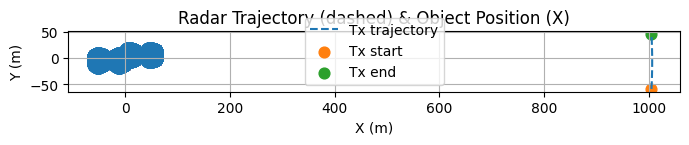

In [ ]:
sensor_xyz = sar.get_sensor_positions()
plot_radar_trajectory_and_object(
    object_xyz=c_objs,
    tx_traj=sensor_xyz, rx_traj=sensor_xyz,
    bistatic=False,          # True로 바꾸면 Tx/Rx 둘 다 점선 표시
)

In [ ]:
# bp_image, xi, yi = sar.backprojection_image(signal=p_signal, coarse_pulse_stride=8)
bp_image, xi, yi, range_gate, auto_gate_used = sar.backprojection_image_fused(signal=p_signal, 
                                                  use_complex64=True,
                                                  auto_gate=False,
                                                  nx_coarse=96, ny_coarse=96, coarse_pulse_stride=4,
                                                  use_power_peak=False
                                                  
                                                  )


[BP fused chunk] pulses 0-9999 done
[BP fused chunk] pulses 10000-19999 done
[BP fused chunk] pulses 20000-29999 done
[BP fused chunk] pulses 30000-39999 done
[BP fused chunk] pulses 40000-49999 done
[BP fused chunk] pulses 50000-56607 done


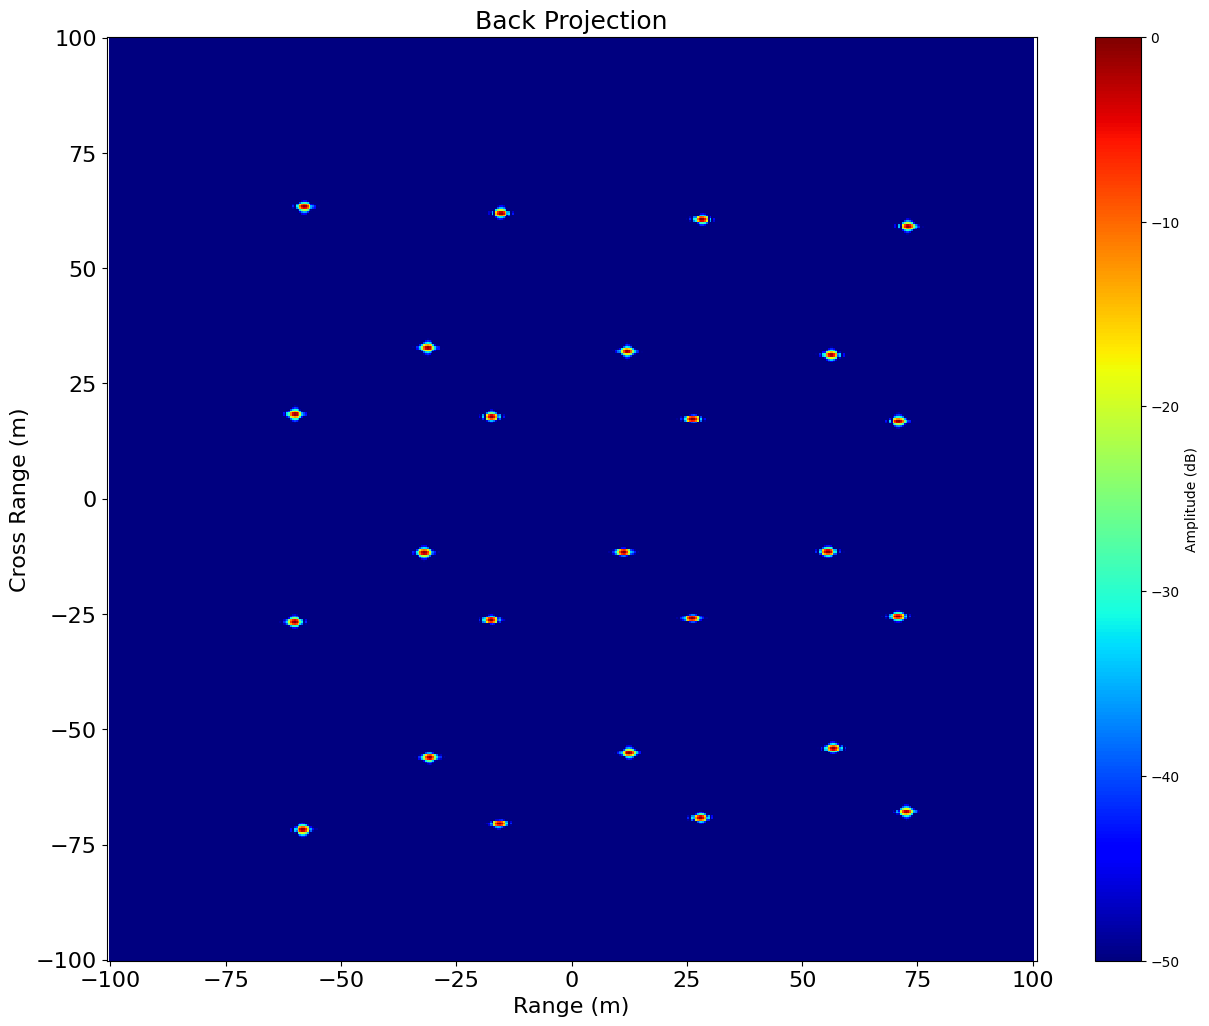

In [10]:

dynamic_range = 50
# Set the figure size
plt.rcParams["figure.figsize"] = (15, 12)

# Plot the backprojected image
plt.figure()
plt.pcolor(xi, yi, 20 * np.log10(np.abs(bp_image) / np.max(np.abs(bp_image))), cmap='jet', vmin=-abs(dynamic_range), vmax=0)

# Set the title and labels
plt.title('Back Projection', size=18)
plt.xlabel('Range (m)', size=16)
plt.ylabel('Cross Range (m)', size=16)



# Make the axes equal
plt.axis('equal')

# Set the tick label size
plt.tick_params(labelsize=16)

# Turn on the colorbar and set the label
cbar = plt.colorbar()
cbar.set_label('Amplitude (dB)')

# Show the figure
plt.show()

In [9]:
# (옵션) 씬 확인

plotter = pv.Plotter()
plotter.add_mesh(
    terrain_mesh,
    # color="lightgray",
    cmap="terrain",
    show_edges=True,
    edge_color="black",
    line_width=0.5
    )
# plotter.add_mesh(terrain_mesh, scalars="elevation", cmap="terrain", show_edges=False)
for obj in obj_meshes:
    plotter.add_mesh(obj, color="lightgray", show_edges=False)
    
all_bounds = None

for obj in obj_meshes:
    if obj.n_points == 0:
        continue
    b = np.array(obj.bounds)  # (xmin,xmax,ymin,ymax,zmin,zmax)
    all_bounds = b if all_bounds is None else np.array([
        min(all_bounds[0], b[0]), max(all_bounds[1], b[1]),
        min(all_bounds[2], b[2]), max(all_bounds[3], b[3]),
        min(all_bounds[4], b[4]), max(all_bounds[5], b[5]),
    ])
print("scene bounds:", all_bounds)
print("terrain bound:", terrain_mesh.bounds[0], terrain_mesh.bounds[1], terrain_mesh.bounds[2],
      terrain_mesh.bounds[3], terrain_mesh.bounds[4], terrain_mesh.bounds[5])
# for i, obj in enumerate(obj_meshes):
#     print(i,
#           "n_points:", obj.n_points,
#           "n_cells:", obj.n_cells,
#           "is_all_finite:", np.isfinite(obj.points).all(),
#           "bounds:", obj.bounds)


plotter.camera_position = "xy"   # 위에서 내려다봄
plotter.camera.zoom(1.2)
# plotter.camera.clipping_range = (0.1, 2e3)  # ✅ 멀리 있는 큰 씬이면 효과 큼

# plotter.camera_position = [
#     (1000, -1000, 800),  # camera
#     (0, 0, 0),           # focal point
#     (0, 0, 1)            # up vector
# ]
plotter.add_axes()
plotter.show()

scene bounds: [ -55.64562988   55.64562988   -2.5798068     4.33261299 1047.0369873
 1078.99182129]
terrain bound: -990.0000000000582 989.9999999999418 -989.9999999990687 990.0000000009313 674.5540161132812 1116.1820068359375


Widget(value='<iframe src="http://localhost:45037/index.html?ui=P_0x7a45619261d0_0&reconnect=auto" class="pyvi…